In [1]:
print('Start import')
import socket 
import strax
import straxen
import numpy as np
import datetime
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import datetime
import pandas as pd
print(
f'''Working on {socket.getfqdn()} with the following versions 
and installation paths:
strax
\tv{strax.__version__}\t{str(strax.__path__[0])}
straxen
\tv{straxen.__version__}\t{str(straxen.__path__[0])}
''')
from multihist import Hist1d, Histdd
import time
import itertools
import os

from scipy import stats
from straxen import units
from scipy.optimize import curve_fit

import peaks_utility as psu
import drift_diffusion_utility as ddu

Start import
Working on midway2-0463.rcc.local with the following versions 
and installation paths:
strax
	v0.14.0	/dali/lgrandi/strax/strax/strax
straxen
	v0.17.0	/dali/lgrandi/strax/straxen/straxen



In [2]:
st = straxen.contexts.xenonnt_online()

In [3]:
dsets = st.select_runs(exclude_tags=('bad','messy'), run_mode='tpc_commissioning_kr*',
                       available=('event_info','peak_basics'))

Checking data availability: 100%|██████████| 3/3 [15:10<00:00, 303.61s/it]


In [4]:
dsets_1 = dsets[(dsets.end > pd.to_datetime('01/23/2021')) & (dsets.number<12245) & (dsets.livetime>np.timedelta64(30,'m'))]
run_1, nn_1 = np.array(dsets_1['name']), len(dsets_1)
dsets_2 = dsets[(dsets.number>=12245) & (dsets.number<=12443) & (dsets.livetime>np.timedelta64(30,'m'))]
run_2, nn_2 = np.array(dsets_2['name']), len(dsets_2)
print('Number of runs:\n',nn_1,'with liquid level at 4.8 mm\n',nn_2,'with liquid level at 5.5 mm')

Number of runs:
 40 with liquid level at 4.8 mm
 106 with liquid level at 5.5 mm


In [5]:
def diffusion_analysis(run_kr, area_cut=(5e3,1.1e4), fit_range=(1,1500), plot = False ):
    run = int(run_kr)
    events = st.get_df(run_kr,'event_info_double',progress_bar=False)
    if(plot): ddu.plot_area_width_aft_kr(events, run_kr)
    mask_singleS1 = ddu.mask_KrSingleS1(events)
    if(plot): ddu.plot_area_width_aft_kr(events[mask_singleS1], run_kr)
    e1 = events[mask_singleS1]
    mask_awt = ddu.mask_s2_area_width_aft_kr(e1,run_kr,area_cut,width_cut=(200,1.5e4),aft_cut=(0.65,0.77),plot=plot)
    e2 = events[mask_singleS1 & mask_awt]
    vd, vd_err, cathodedt, gatedt, s2shift = ddu.drift_velocity_kr(e1, run_kr, plot=plot)
    d, d_err = ddu.diffusion_constant_kr(e2,run_kr,fit_range=(1,1500),vd = vd,plot=plot)
    if ((cathodedt>2000) & (gatedt>2) & (d_err<0.2)): return run, vd, vd_err, d, d_err, cathodedt, gatedt, s2shift
    else: return run, 0, 0, 0, 0, 0, 0, 0

Drift velocity = 0.629~mm/$\mu$s
Diffusion constant = 42.49 +/- 0.19 cm$^2$/s 


(12200,
 0.6287204182359399,
 0.002658606246290307,
 42.48775205572023,
 0.1927304211454201,
 2364.849699398798,
 2.909547738693467,
 6.060301507537688)

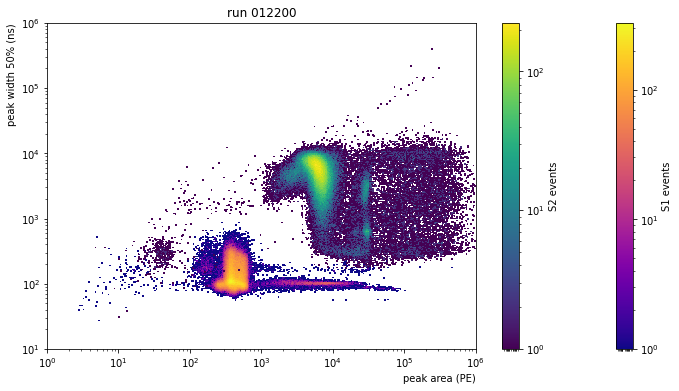

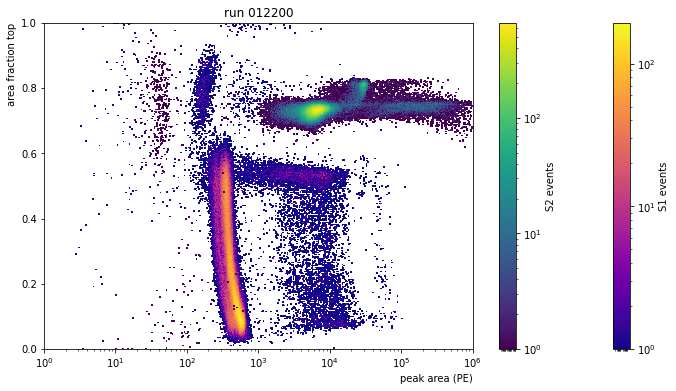

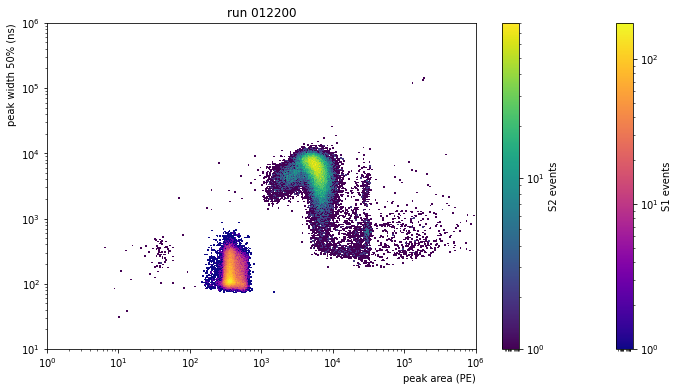

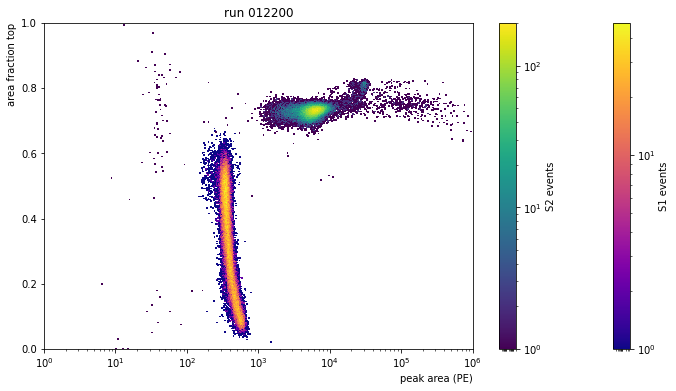

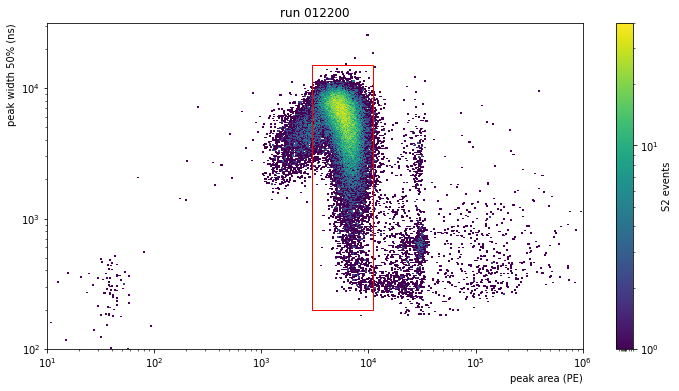

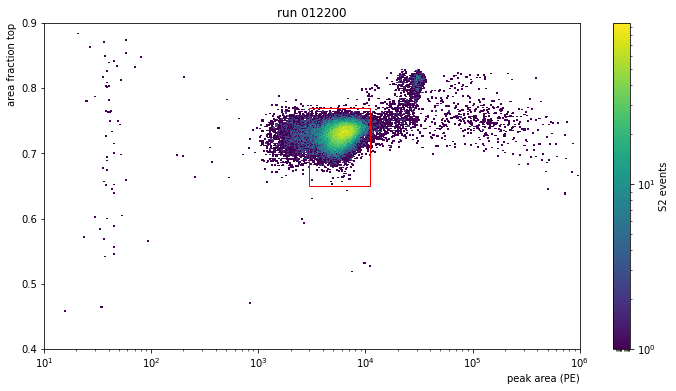

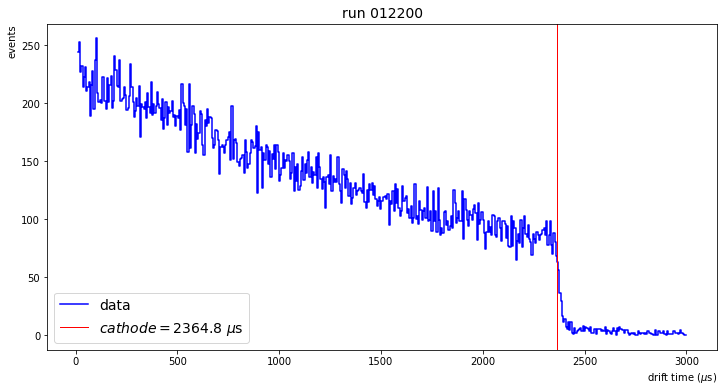

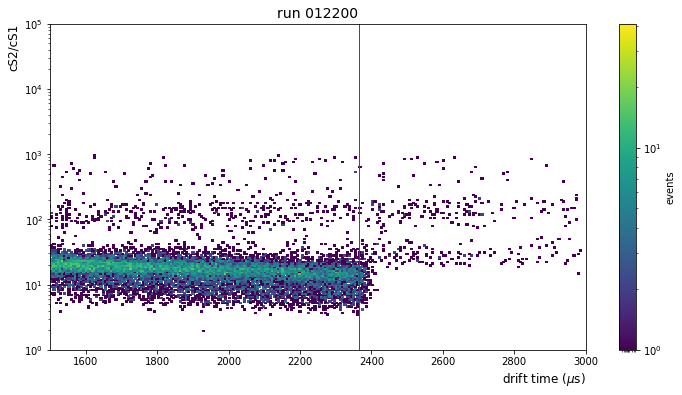

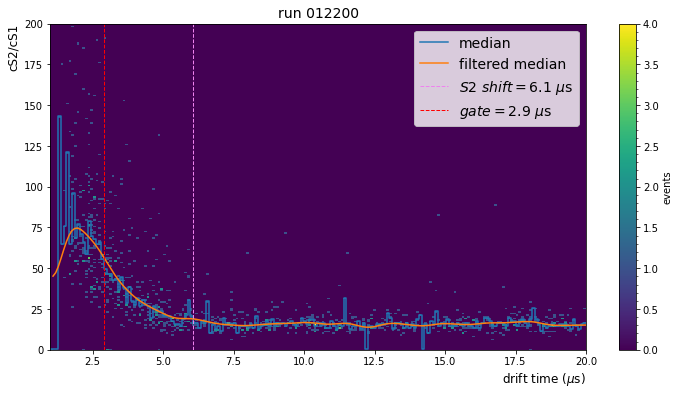

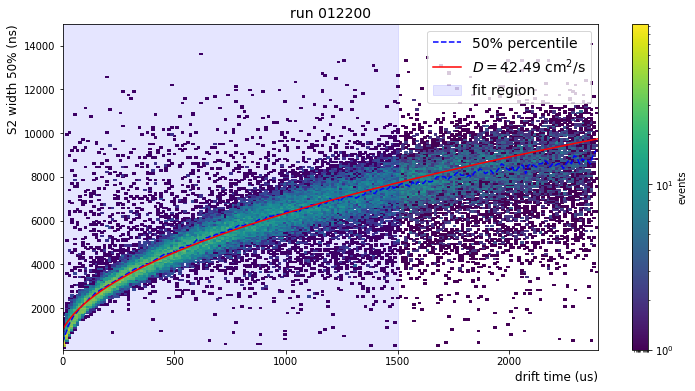

In [6]:
diffusion_analysis('012200',area_cut=(3e3,1.1e4),fit_range=(1,1500), plot = True)

Drift velocity = 0.629~mm/$\mu$s
Diffusion constant = 42.63 +/- 0.13 cm$^2$/s 


(12245,
 0.6286950043167308,
 0.0026584987810284954,
 42.63406464639728,
 0.13217522196796752,
 2364.849699398798,
 2.8140703517587937,
 5.6783919597989945)

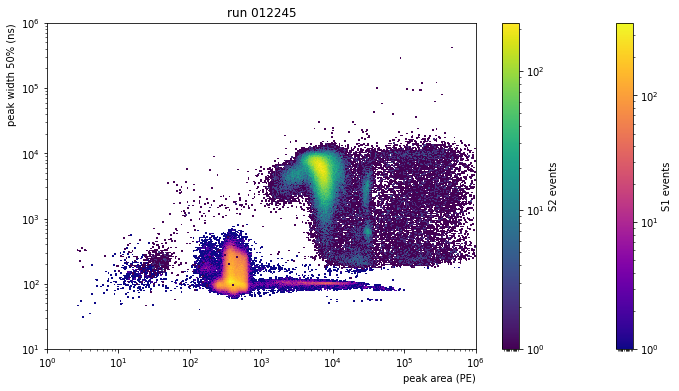

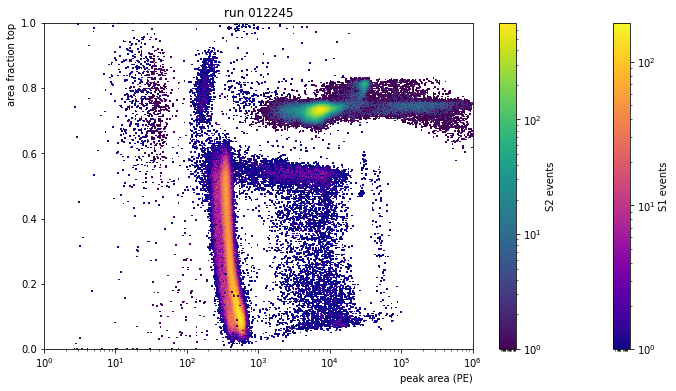

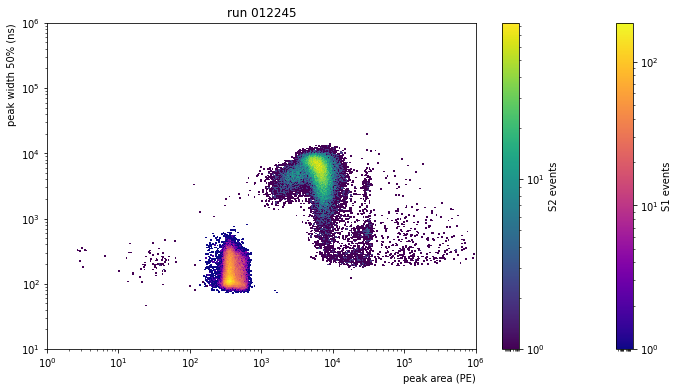

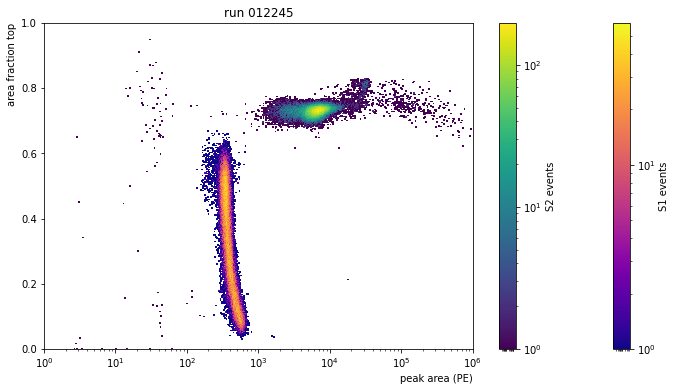

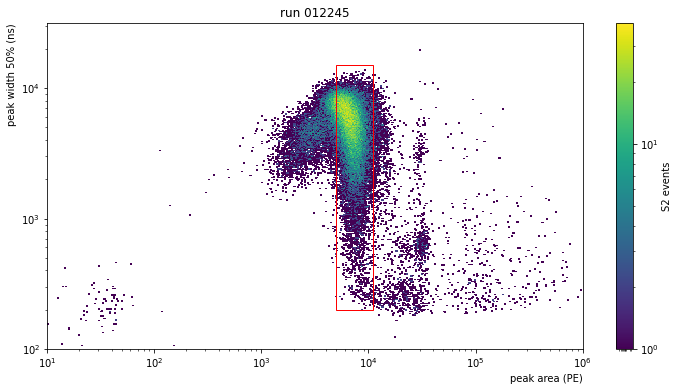

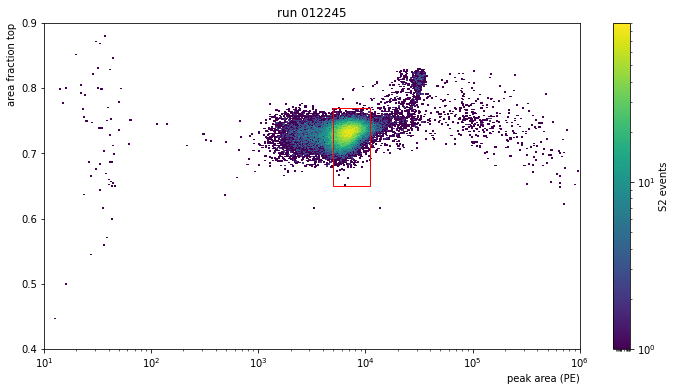

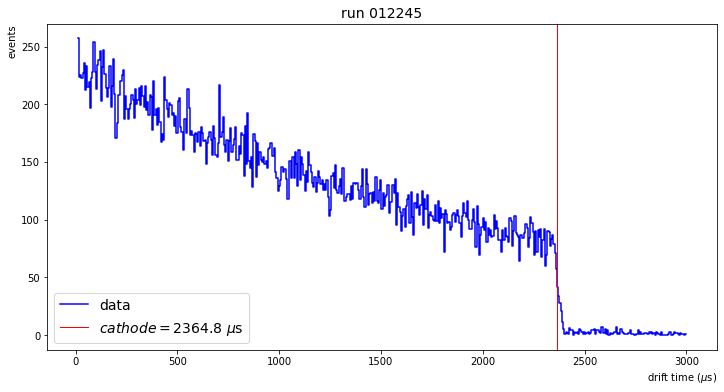

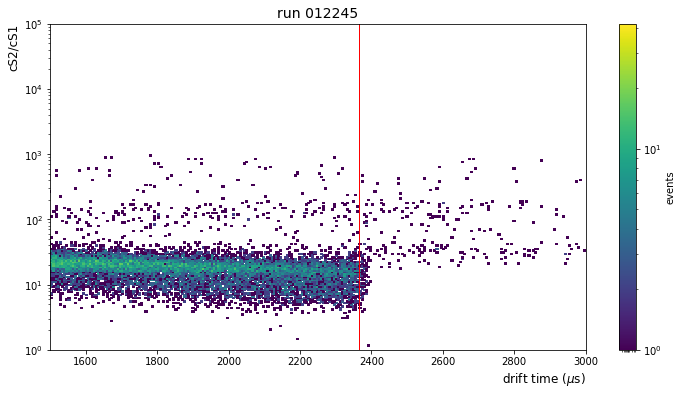

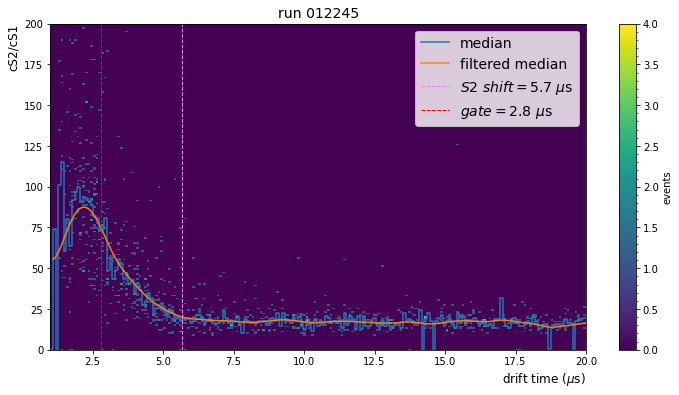

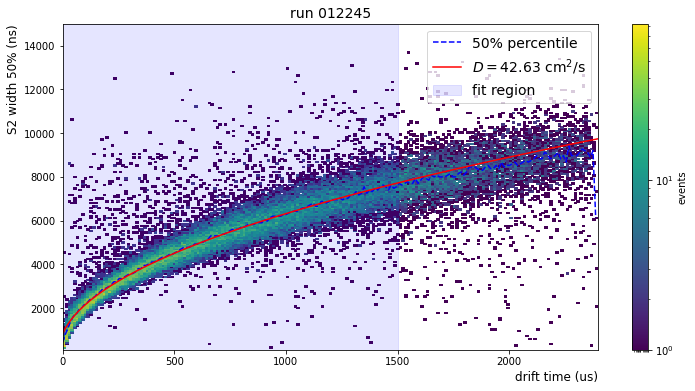

In [7]:
diffusion_analysis('012245',area_cut=(5e3,1.1e4),fit_range=(1,1500), plot = True)

In [8]:
runs, vd, vd_err, d, d_err = np.zeros(nn_1), np.zeros(nn_1), np.zeros(nn_1), np.zeros(nn_1), np.zeros(nn_1)
cc, gg, ss = np.zeros(nn_1), np.zeros(nn_1), np.zeros(nn_1)
for i, run in enumerate(run_1):
    runs[i], vd[i], vd_err[i], d[i], d_err[i], cc[i], gg[i], ss[i] = diffusion_analysis(run, area_cut=(3e3,1.1e4))

In [9]:
runs2, vd2, vd_err2, d2, d_err2 = np.zeros(nn_2), np.zeros(nn_2), np.zeros(nn_2), np.zeros(nn_2), np.zeros(nn_2)
cc2, gg2, ss2 = np.zeros(nn_2), np.zeros(nn_2), np.zeros(nn_2)
for i, run in enumerate(run_2):
    runs2[i], vd2[i], vd_err2[i], d2[i], d_err2[i], cc2[i], gg2[i], ss2[i] = diffusion_analysis(run, area_cut=(5e3,1.1e4))

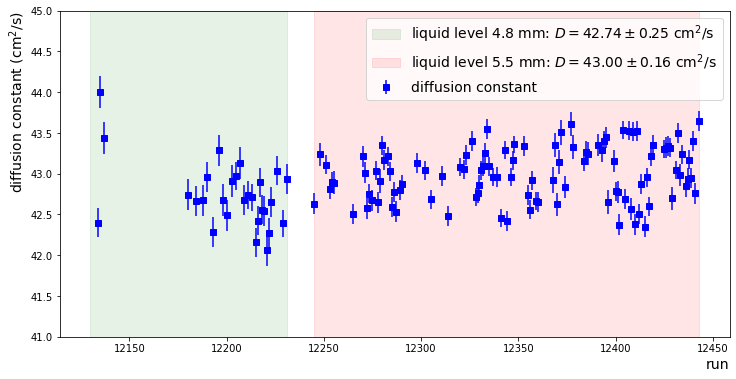

In [10]:
rr, dd, dd_err = np.concatenate((runs,runs2)), np.concatenate((d,d2)), np.concatenate((d_err,d_err2))
plt.figure(figsize=(12,6))
plt.xlabel("run", ha='right', x=1,fontsize=14)
plt.ylabel("diffusion constant (cm$^2$/s)", ha='right', y=1,fontsize=14)
plt.errorbar(rr, dd, yerr = dd_err, fmt='s',c='b',label='diffusion constant')
mean1, mean2 = d[d>0].mean(), d2[d2>0].mean()
std1, std2 = d[d>0].std()/np.sqrt(np.size(d))+d_err[d>0].mean(), d2[d2>0].std()/np.sqrt(np.size(d2))+d_err2[d2>0].mean()
plt.axvspan(12130,12231, alpha=0.1, color='g',
            label=f'liquid level 4.8 mm: $D = {mean1:.2f} \pm {std1:.2f}$ cm$^2$/s')
plt.axvspan(12245,12443, alpha=0.1, color='r',
            label=f'liquid level 5.5 mm: $D = {mean2:.2f} \pm {std2:.2f}$ cm$^2$/s')
plt.ylim(41,45)
plt.legend(fontsize=14)

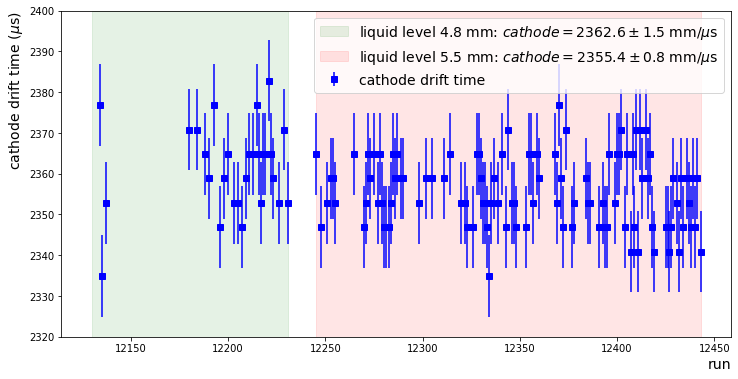

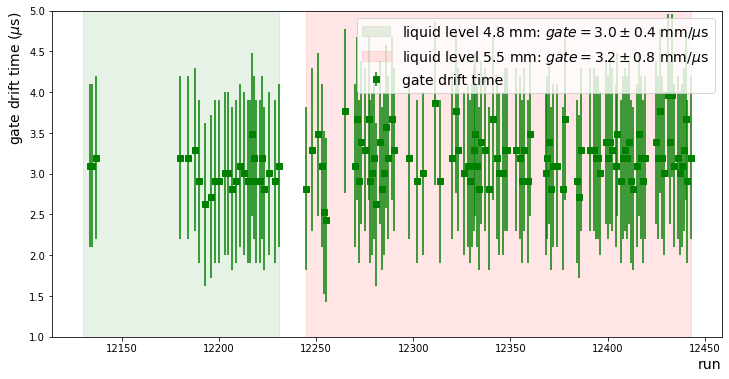

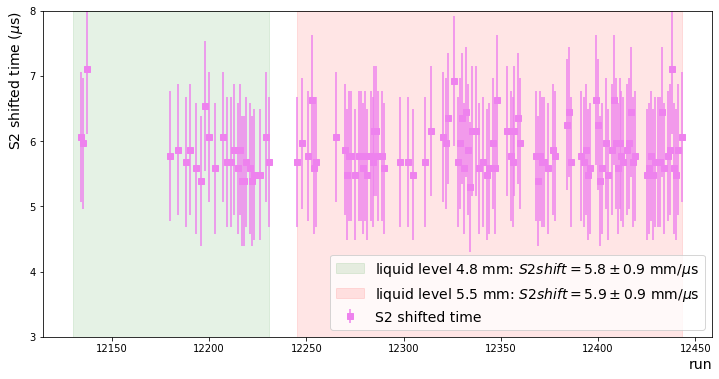

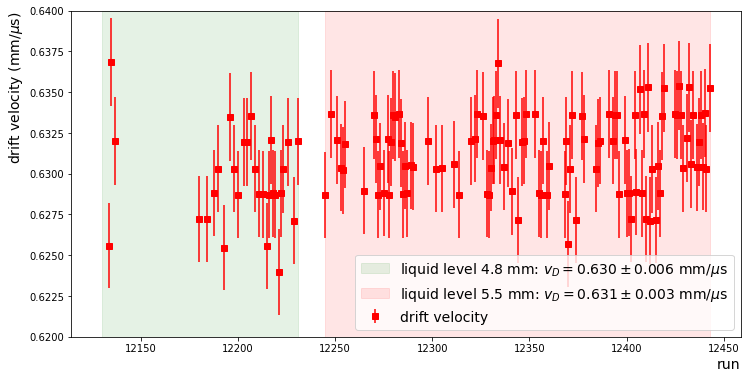

In [11]:
rr, vdd, vdd_err = np.concatenate((runs,runs2)), np.concatenate((vd,vd2)), np.concatenate((vd_err,vd_err2))
cat, gat, s2shift = np.concatenate((cc,cc2)), np.concatenate((gg,gg2)), np.concatenate((ss,ss2))

### cathode drop-off
plt.figure(figsize=(12,6))
plt.xlabel("run", ha='right', x=1,fontsize=14)
plt.ylabel("cathode drift time ($\mu$s)", ha='right', y=1,fontsize=14)
plt.errorbar(rr,cat,yerr=10,fmt='s',color='b',label='cathode drift time')
cm1, cm2 = cc[cc>2340].mean(), cc2[cc2>0].mean()
cs1, cs2 = cc[cc>2340].std()/np.sqrt(np.size(cc)), cc2[cc2>2340].std()/np.sqrt(np.size(cc2))
plt.axvspan(12130,12231, alpha=0.1, color='g',
            label=f'liquid level 4.8 mm: $cathode = {cm1:.1f} \pm {cs1:.1f}$ mm/$\mu$s')
plt.axvspan(12245,12443, alpha=0.1, color='r',
            label=f'liquid level 5.5 mm: $cathode = {cm2:.1f} \pm {cs2:.1f}$ mm/$\mu$s')
plt.ylim(2320,2400)
plt.legend(fontsize=14)

### gate drift time
plt.figure(figsize=(12,6))
plt.xlabel("run", ha='right', x=1,fontsize=14)
plt.ylabel("gate drift time ($\mu$s)", ha='right', y=1,fontsize=14)
plt.errorbar(rr,gat,yerr=1,fmt='s',color='g',label='gate drift time')
gm1, gm2 = gg[gg>0].mean(), gg2[gg2>0].mean()
gs1, gs2 = (gg[gg>0].max()-gg[gg>0].min())/2, (gg2[gg2>0].max()-gg2[gg2>0].min())/2
plt.axvspan(12130,12231, alpha=0.1, color='g',
            label=f'liquid level 4.8 mm: $gate = {gm1:.1f} \pm {gs1:.1f}$ mm/$\mu$s')
plt.axvspan(12245,12443, alpha=0.1, color='r',
            label=f'liquid level 5.5 mm: $gate = {gm2:.1f} \pm {gs2:.1f}$ mm/$\mu$s')
plt.legend(fontsize=14)
plt.ylim(1,5)

### S2 shift time
plt.figure(figsize=(12,6))
plt.xlabel("run", ha='right', x=1,fontsize=14)
plt.ylabel("S2 shifted time ($\mu$s)", ha='right', y=1,fontsize=14)
plt.errorbar(rr,s2shift,yerr=1,fmt='s',color='violet',label='S2 shifted time')
sme1, sme2 = ss[ss>2].mean(), ss2[ss2>2].mean()
sst1, sst2 = (ss[ss>2].max()-ss[ss>2].min())/2, (ss2[ss2>2].max()-ss2[ss2>2].min())/2
plt.axvspan(12130,12231, alpha=0.1, color='g',
            label=f'liquid level 4.8 mm: $S2 shift = {sme1:.1f} \pm {sst1:.1f}$ mm/$\mu$s')
plt.axvspan(12245,12443, alpha=0.1, color='r',
            label=f'liquid level 5.5 mm: $S2 shift = {sme2:.1f} \pm {sst2:.1f}$ mm/$\mu$s')
plt.legend(fontsize=14)
plt.ylim(3,8)

# drif velocity
plt.figure(figsize=(12,6))
plt.xlabel("run", ha='right', x=1,fontsize=14)
plt.ylabel("drift velocity (mm/$\mu$s)", ha='right', y=1,fontsize=14)
plt.errorbar(rr,vdd,yerr=vdd_err,fmt='s',color='r',label='drift velocity')
m1, m2 = vd[vd>0].mean(), vd2[vd2>0].mean()
s1, s2 = vd[vd>0].std()/np.sqrt(np.size(vd))+vd_err[vd>0].mean()+vd_err[vd>0].mean(), vd2[vd2>0].std()/np.sqrt(np.size(vd2))+vd_err2[vd2>0].mean()
plt.axvspan(12130,12231, alpha=0.1, color='g',
            label=f'liquid level 4.8 mm: $v_D = {m1:.3f} \pm {s1:.3f}$ mm/$\mu$s')
plt.axvspan(12245,12443, alpha=0.1, color='r',
            label=f'liquid level 5.5 mm: $v_D = {m2:.3f} \pm {s2:.3f}$ mm/$\mu$s')
plt.ylim(0.62,0.64)
plt.legend(fontsize=14)

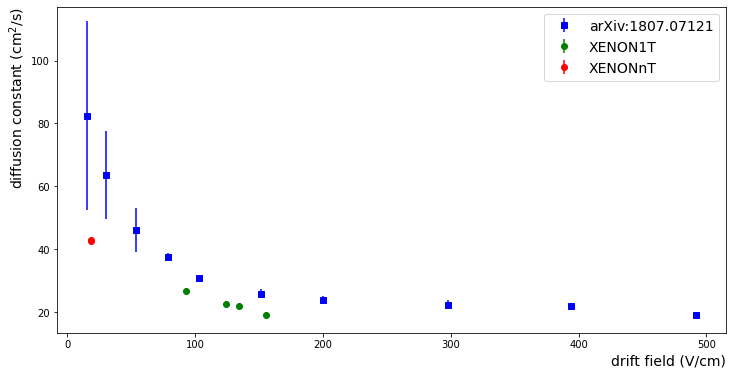

In [15]:
with open("DiffusionConstantHogenbirk.txt") as f:
    data = f.read()
data = data.split('\n')
ff = [row.split(' ')[0] for row in data]
dd = [row.split(' ')[1] for row in data]
de = [row.split(' ')[2] for row in data]
ff, dd, de = np.array(ff, dtype=np.float32), np.array(dd, dtype=np.float32), np.array(de, dtype=np.float32)
plt.figure(figsize=(12,6))
plt.errorbar(ff,dd,yerr=de, c='b', fmt='s', label='arXiv:1807.07121')
field_1T = [155,134,124,92.8]
diff_1T = [19.2, 21.9, 22.8, 26.8]
field_nT = [18.3,18.3]
diff_nT = [43.13, 42.51]
diff_nT_err = [0.06, 0.02]
plt.errorbar(field_1T,diff_1T,yerr=0.8,fmt='o',color='g',label='XENON1T')
plt.errorbar(field_nT,diff_nT,yerr=diff_nT_err,fmt='o',color='r',label='XENONnT')
plt.xlabel("drift field (V/cm)", ha='right', x=1,fontsize=14)
plt.ylabel("diffusion constant (cm$^2$/s)", ha='right', y=1,fontsize=14)
plt.legend(fontsize=14)